In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

## Load dataset

In [3]:
# sonnets.txt
#!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

In [4]:
with open('Datasets/sonnets.txt') as f:
    sonnets = f.read()

sonnets_list = sonnets.lower().split("\n")
print(len(sonnets_list))
sonnets_list[:10]

2159


['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

## Text preprocessing

In [5]:
vec_layer_sonnets = tf.keras.layers.TextVectorization()
vec_layer_sonnets.adapt(sonnets_list)
vectorized_sonnets = vec_layer_sonnets(sonnets_list)
vocab_size = vec_layer_sonnets.vocabulary_size()
print(vocab_size,vectorized_sonnets.shape)
vec_layer_sonnets.get_vocabulary()[:10]

3189 (2159, 11)


['', '[UNK]', 'and', 'the', 'to', 'of', 'my', 'i', 'in', 'that']

In [17]:
def pad_vectorized_sequences(inp_text,vec_layer,output_rows,output_cols):
    phrases = np.zeros(shape=(output_rows,output_cols))
    labels = np.zeros(shape=(output_rows,1))
    row = 0
    for line in inp_text:
        words = line.split()
        for num_words in range(1,len(words)):
            phr = ''
            for i in range(num_words+1):
                phr += words[i] + ' '
            phr = phr.strip() #Strip trailing and leading whitespaces
            vec_phrase = list(vec_layer(phr).numpy())
            cols = len(vec_phrase)-1
            phrases[row,:cols] = vec_phrase[0:-1]
            labels[row] = vec_phrase[-1]
            row += 1
    return phrases,labels

total_phrase_count = 0
for line in sonnets_list:
    total_phrase_count += len(line.split()) - 1
total_phrase_count += 3 ######### Dont know why- Need to debug
line_length = vectorized_sonnets.shape[1]
print("Output Seq length = ",line_length)
print("Total no.of phrases = ",total_phrase_count)

phrases,labels = pad_vectorized_sequences(sonnets_list,vec_layer_sonnets,total_phrase_count,line_length)
print(phrases.shape,labels.shape)
print(phrases[:3])
print(labels[:3])

Output Seq length =  11
Total no.of phrases =  15355
(15355, 11) (15355, 1)
[[  35.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  35.  489.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  35.  489. 1259.    0.    0.    0.    0.    0.    0.    0.    0.]]
[[ 489.]
 [1259.]
 [ 164.]]


In [21]:
def test_labelgen(check_input):
    vec_inp = []
    vec_inp_arr = np.zeros(shape=(1,line_length))
    for word in check_input.lower().split():
        code = vec_layer_sonnets.get_vocabulary().index(word)
        vec_inp.append(code)
    col = len(vec_inp)
    vec_inp_arr[0,:col] = np.array(vec_inp)

    inp_idx = None
    row = 0
    for phr in phrases:
        j = 0
        for i in range(len(phr)):
            if vec_inp_arr[0,i] == phr[i]:
                j +=1
        if j == len(phr):
            inp_idx = row
            break
        row += 1
    print(inp_idx,"=>",phrases[inp_idx])
    check_label = int(labels[inp_idx,0])
    return vec_layer_sonnets.get_vocabulary()[check_label]

test_labelgen('and only herald to the gaudy')

62 => [   2.  376. 2433.    4.    3. 2514.    0.    0.    0.    0.    0.]


'spring'

In [22]:
# One-hot encoding of labels
labels_categ = tf.keras.utils.to_categorical(y=labels,num_classes=vocab_size) #Any word in the Vocabulary can be the label (as text gets generated in the future)
print(labels_categ.shape)
print(labels_categ[0])

(15355, 3189)
[0. 0. 0. ... 0. 0. 0.]


## Model

In [43]:
sonnets_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=100,input_length=line_length),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=250)), #activation='tanh'

    tf.keras.layers.Dense(units=vocab_size,activation='softmax')
])

sonnets_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

sonnets_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 11, 100)           318900    
                                                                 
 bidirectional_7 (Bidirectio  (None, 500)              702000    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 3189)              1597689   
                                                                 
Total params: 2,618,589
Trainable params: 2,618,589
Non-trainable params: 0
_________________________________________________________________


In [44]:
sonnets_model_hist = sonnets_model.fit(x=phrases,y=labels_categ,epochs=50)

Epoch 1/50
480/480 [==============================] - 6s 8ms/step - loss: 6.8828 - accuracy: 0.0209
Epoch 2/50
480/480 [==============================] - 3s 7ms/step - loss: 6.5077 - accuracy: 0.0274
Epoch 3/50
480/480 [==============================] - 4s 7ms/step - loss: 6.3322 - accuracy: 0.0317
Epoch 4/50
480/480 [==============================] - 4s 7ms/step - loss: 6.0963 - accuracy: 0.0402
Epoch 5/50
480/480 [==============================] - 4s 8ms/step - loss: 5.7883 - accuracy: 0.0526
Epoch 6/50
480/480 [==============================] - 4s 7ms/step - loss: 5.3463 - accuracy: 0.0683
Epoch 7/50
480/480 [==============================] - 3s 7ms/step - loss: 4.7608 - accuracy: 0.0981
Epoch 8/50
480/480 [==============================] - 4s 7ms/step - loss: 4.0871 - accuracy: 0.1642
Epoch 9/50
480/480 [==============================] - 3s 7ms/step - loss: 3.4050 - accuracy: 0.2766
Epoch 10/50
480/480 [==============================] - 4s 7ms/step - loss: 2.8186 - accuracy: 0.3826

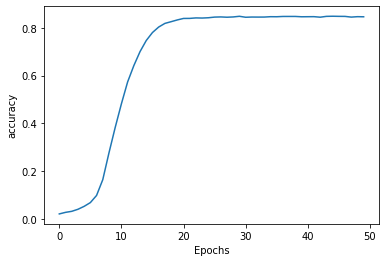

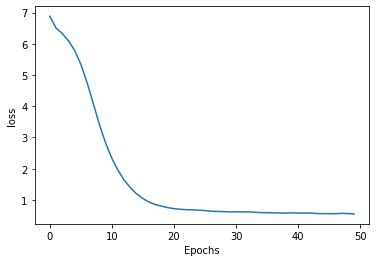

In [45]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  #plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  #plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(sonnets_model_hist, "accuracy")
plot_graphs(sonnets_model_hist, "loss")

## Text Generation

In [58]:
starter_text = "Honey went to Dublin"
num_words_to_predict = 100

for i in range(num_words_to_predict):
    veczd_starter_text = np.zeros(shape=(vocab_size))
    vec_txt = vec_layer_sonnets(starter_text).numpy()
    veczd_starter_text[:len(vec_txt)] = vec_txt
    veczd_starter_text = veczd_starter_text.reshape(-1,vocab_size)

    prob = sonnets_model.predict(veczd_starter_text)
    prob_idx = np.argmax(prob)
    predicted_word = vec_layer_sonnets.get_vocabulary()[prob_idx]

    starter_text += ' ' + predicted_word

print(starter_text)

1/1 [==============================] - 0s 203ms/step
Honey went to Dublin the praise at a must have by their no and no must eyes make to is but praise no must see yield praise no fell present have air in by by by mine is in must date from to yield in the must weeds doth doth is for their must praise doth their have at by from praise must must each must their must the doth weeds their weeds their must must doth the the the each their their their the strengthend by must must their their their is their their make have have have must must must must the
